# Variables correlation

Look at the correlation between variables that will go into the GLM

In [1]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from myterial import amber_dark, blue_dark, green_dark, indigo_dark, teal_dark

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from fcutils.plot.figure import clean_axes
from fcutils.plot.elements import plot_mean_and_error
from fcutils.progress import track
from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts, trim_bouts
from fcutils.maths import derivative

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")


[06/11/22 14:57:26] DEBUG    DPL - Saving data and logs to logs                   ]8;id=894146;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=165116;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#118\118]8;;\

                    DEBUG    Saving log file to: logs\log.log                     ]8;id=417867;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=751818;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#119\119]8;;\

Connecting root@127.0.0.1:3306


[06/11/22 14:57:27] DEBUG    Connected to database: LOCOMOTION4                ]8;id=370359;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py\__init__.py]8;;\:]8;id=961724;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py#11\11]8;;\

## Fetch data

Start by pre-computing the shifted curvature at heach point along the track. 
For each row in the resulting dataframe you have the curren S and then the curvature shifted by N cm.

In [51]:
track_data = pd.read_json(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\track.json").iloc[::25]
track_data = track_data.reset_index(drop=True)
S_f = track_data.S.values[-1]
track_data

,S,X,Y,curvature,width,θ
0,0.000000,20.005419,32.926672,1.397851e-08,3.600000,-1.562696
1,0.034248,20.005696,32.892425,2.407125e-04,3.596612,-1.562692
2,0.068464,20.005974,32.858210,4.834723e-04,3.590541,-1.562680
3,0.102616,20.006251,32.824059,7.303402e-04,3.584550,-1.562659
4,0.136672,20.006529,32.790004,9.834296e-04,3.578645,-1.562630
...,...,...,...,...,...,...
3996,265.273224,3.999664,7.342840,3.530815e-05,3.600000,-1.570627
3997,265.334935,3.999675,7.281129,2.648609e-05,3.600000,-1.570625
3998,265.396642,3.999685,7.219422,1.766084e-05,3.600000,-1.570624
3999,265.458347,3.999696,7.157717,8.831522e-06,3.600000,-1.570623


In [52]:
# load track from json
k_shifts = np.arange(50)
curv_shifted = {
    **{f"k_{k}":[] for k in k_shifts},
    **{f"idx_{k}":[] for k in k_shifts},
}
for i, s in enumerate(track_data.S):
    if i % 250 == 0:
        print(i, len(track_data))
    for k in k_shifts:
        if s + k < S_f:
            select = track_data.loc[track_data.S >= s + k]
            curv_shifted[f"idx_{k}"].append(select.index[0])
            curv_shifted[f"k_{k}"].append(select["curvature"].iloc[0])
        else:
            curv_shifted[f"k_{k}"].append(np.nan)
            curv_shifted[f"idx_{k}"].append(np.nan)

    # break

for k,v in curv_shifted.items():
    track_data.insert(2, k, v)
track_data.head()

0 4001
250 4001
500 4001
750 4001
1000 4001
1250 4001
1500 4001
1750 4001
2000 4001
2250 4001
2500 4001
2750 4001
3000 4001
3250 4001
3500 4001
3750 4001
4000 4001


,S,X,idx_49,idx_48,idx_47,idx_46,idx_45,idx_44,idx_43,idx_42,...,k_5,k_4,k_3,k_2,k_1,k_0,Y,curvature,width,θ
0,0.000000,20.005419,727.0,711.0,695.0,679.0,664.0,649.0,635.0,622.0,...,0.014435,0.011079,0.011057,0.004578,0.005121,1.397851e-08,32.926672,1.397851e-08,3.600000,-1.562696
1,0.034248,20.005696,727.0,711.0,695.0,680.0,665.0,650.0,636.0,622.0,...,0.014729,0.011079,0.011057,0.004907,0.004178,2.407125e-04,32.892425,2.407125e-04,3.596612,-1.562692
2,0.068464,20.005974,728.0,712.0,696.0,680.0,665.0,650.0,636.0,623.0,...,0.015033,0.011253,0.011257,0.004907,0.003339,4.834723e-04,32.858210,4.834723e-04,3.590541,-1.562680
3,0.102616,20.006251,728.0,712.0,696.0,681.0,666.0,651.0,637.0,623.0,...,0.015033,0.011253,0.011431,0.005266,0.002610,7.303402e-04,32.824059,7.303402e-04,3.584550,-1.562659
4,0.136672,20.006529,729.0,713.0,697.0,681.0,666.0,651.0,637.0,623.0,...,0.015348,0.011434,0.011431,0.005266,0.001990,9.834296e-04,32.790004,9.834296e-04,3.578645,-1.562630


[<matplotlib.lines.Line2D object at 0x000002ABE36DC0F0>]

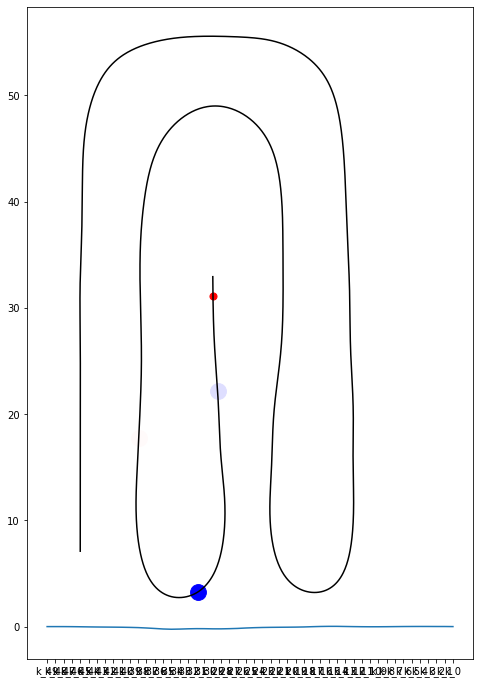

In [48]:
# check that everything went well

row = track_data.iloc[25]

f, ax = plt.subplots(figsize=(8, 12))
ax.plot(track_data.X, track_data.Y, "k")
ax.scatter(row.X, row.Y, c="r", s=50)

idx_cols = [c for c in track_data.columns if c.startswith("idx")][::20]
for c in idx_cols:
    idx = int(row[c])
    ax.scatter(track_data.iloc[idx].X, track_data.iloc[idx].Y, c=track_data.iloc[idx].curvature, vmin=-.1, vmax=.1, cmap="bwr", s=250)

curv_cols = [c for c in track_data.columns if c.startswith("k")]
ax.plot(row[curv_cols])

then collect behavioral variable and curvature + variables offset by various delta T

In [53]:
variables = ("s", "speed", "angular_velocity")
time_shifters = ("speed", "angular_velocity")
time_shifts = (100, 200, 400, 600)

variables_data = {
    **{v:[] for v in variables},
    **{f"{v}_{t}":[] for v in time_shifters for t in time_shifts},
}


for REC in get_recording_names():
    units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    bouts = trim_bouts(get_session_bouts(REC, complete=None, direction=None))

    for i, bout in bouts.iterrows():
        variables_data["speed"].extend(body.speed[bout.trim_start:bout.trim_end])
        variables_data["s"].extend(bout.s[bout.trim_start - bout.start_frame : bout.trim_end - bout.start_frame])
        variables_data["angular_velocity"].extend(body.angular_velocity[bout.trim_start:bout.trim_end] / 60)

        for dt in time_shifts:
            dt_frames = int(dt/1000 * 60)
            variables_data[f"speed_{dt}"].extend(body.speed[bout.trim_start+dt_frames:bout.trim_end+dt_frames])
            variables_data[f"angular_velocity_{dt}"].extend(body.angular_velocity[bout.trim_start+dt_frames:bout.trim_end+dt_frames] / 60)

data = pd.DataFrame(variables_data)
print(len(data) / 60 * 1000)

3847516.666666667


In [54]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)



def fit_line(X, Y,  ax):
    a, b = np.polyfit(X, Y, 1)
    yhat = a*X+b
    r2 = r_squared(Y, yhat)
    ax.plot(X, yhat, lw=3, color='r', label=f"R2={r2:.2f}")
    ax.legend(loc='upper right')


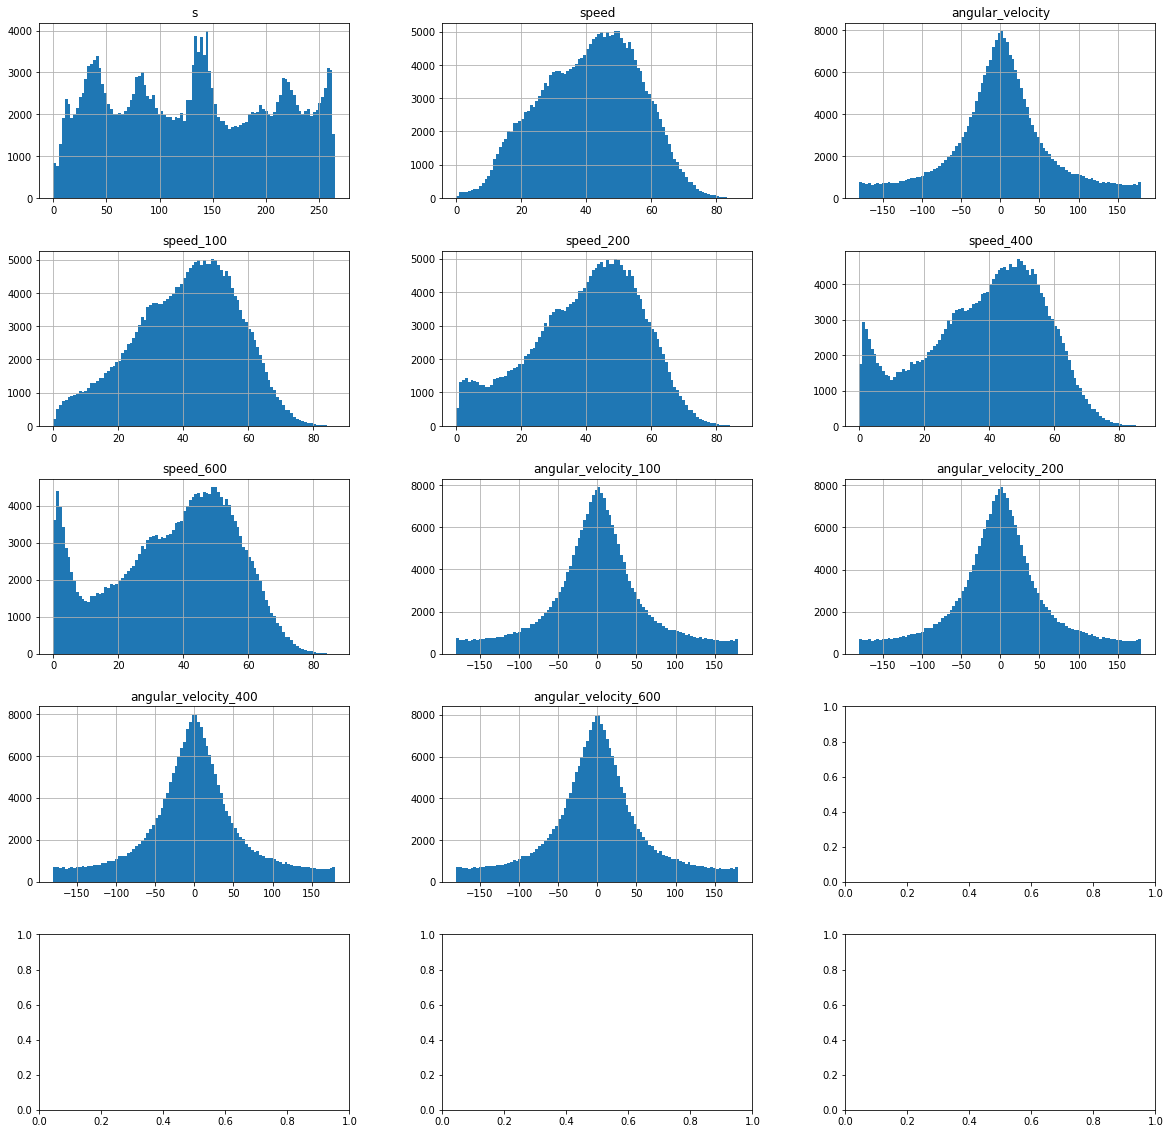

In [55]:
fig, axis = plt.subplots(5,3,figsize=(20, 20))
axes = axis.flatten()[:11]
_ = data.hist(ax=axes, bins=100)

## Plot correlations

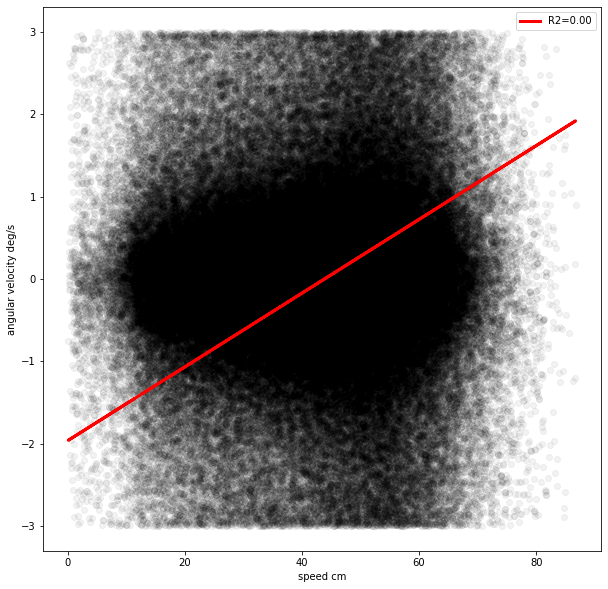

In [56]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(data.speed, data.angular_velocity / 60, color="k", alpha=.05)

fit_line(data.speed, data.angular_velocity, ax)
_ = ax.set(xlabel="speed cm", ylabel="angular velocity deg/s")

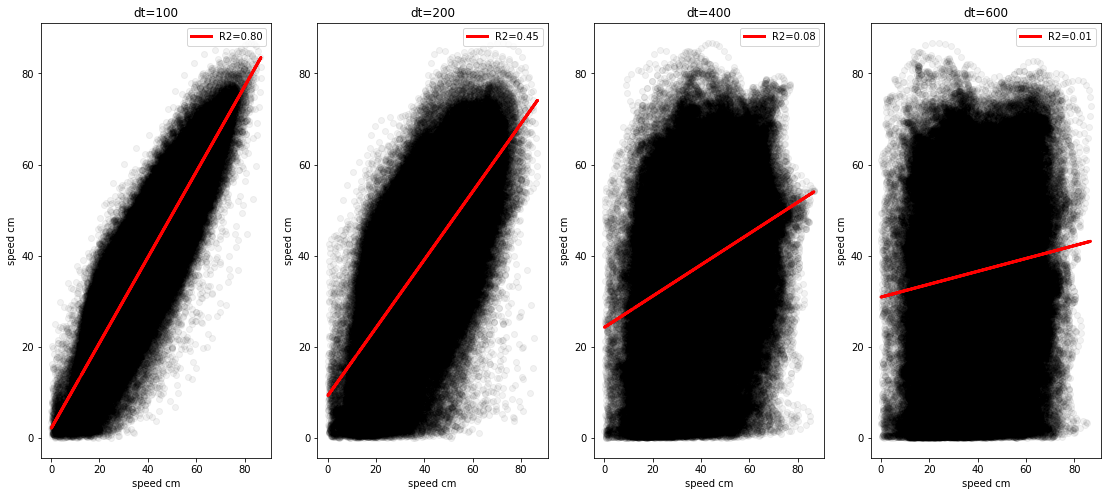

In [57]:
f, axes = plt.subplots(1, len(time_shifts), figsize=(19, 8))

for i, dt in enumerate(time_shifts):
    axes[i].scatter(data.speed, data[f"speed_{dt}"], color="k", alpha=.05)
    axes[i].set(title=f"dt={dt}", xlabel="speed cm", ylabel="speed cm")
    fit_line(data.speed,  data[f"speed_{dt}"], axes[i])

    

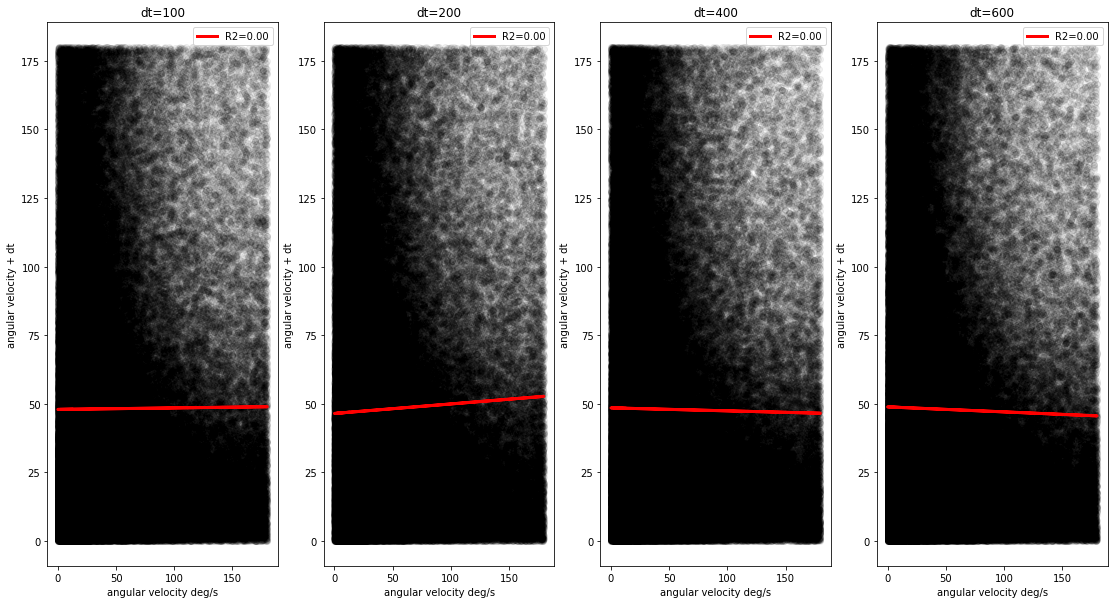

In [58]:
f, axes = plt.subplots(1, len(time_shifts), figsize=(19, 10))

for i, dt in enumerate(time_shifts):
    axes[i].scatter(data.angular_velocity.abs(), data[f"angular_velocity_{dt}"].abs(), color="k", alpha=.05)
    axes[i].set(title=f"dt={dt}", xlabel="angular velocity deg/s", ylabel="angular velocity + dt")

    fit_line(data.angular_velocity.abs(),  data[f"angular_velocity_{dt}"].abs(), axes[i])

    

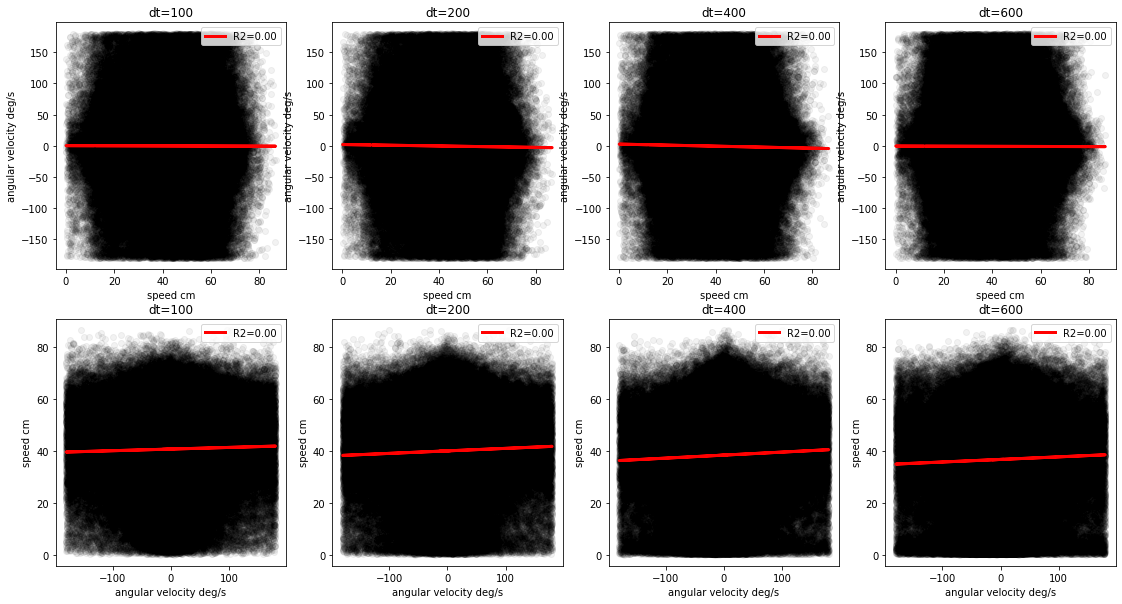

In [59]:
f, axes = plt.subplots(2, len(time_shifts), figsize=(19, 10))

for i, dt in enumerate(time_shifts):
    axes[0, i].scatter(data.speed, data[f"angular_velocity_{dt}"], color="k", alpha=.05)
    axes[0, i].set(title=f"dt={dt}", xlabel="speed cm", ylabel="angular velocity deg/s")
    fit_line(data.speed,  data[f"angular_velocity_{dt}"], axes[0, i])
    

    axes[1, i].scatter(data.angular_velocity, data[f"speed_{dt}"], color="k", alpha=.05)
    axes[1, i].set(title=f"dt={dt}", xlabel="angular velocity deg/s", ylabel="speed cm")
    fit_line(data.angular_velocity,  data[f"speed_{dt}"], axes[1, i])

    

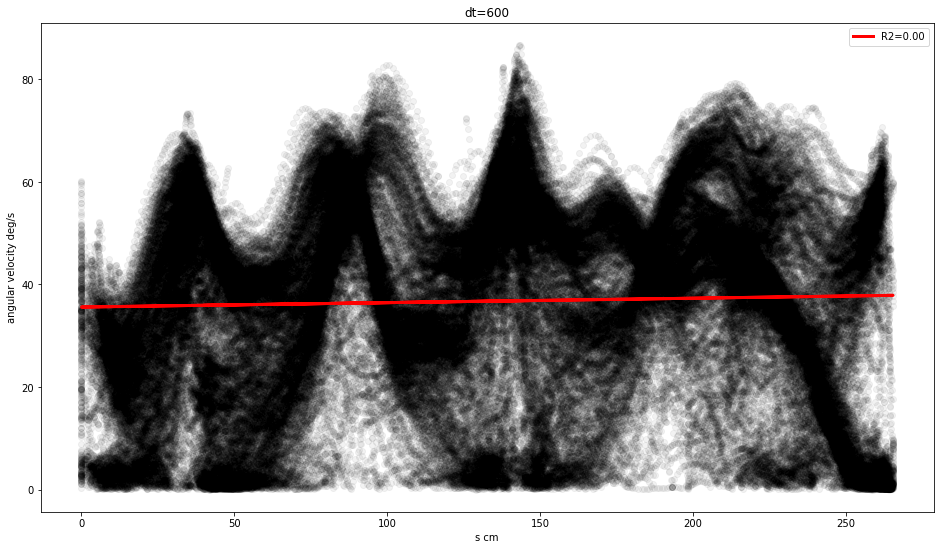

In [60]:
f, ax = plt.subplots(figsize=(16, 9))

ax.scatter(data.s, data.speed_600, color="k", alpha=.05)
ax.set(title=f"dt={dt}", xlabel="s cm", ylabel="angular velocity deg/s")
fit_line(data.s,  data.speed_600, ax)

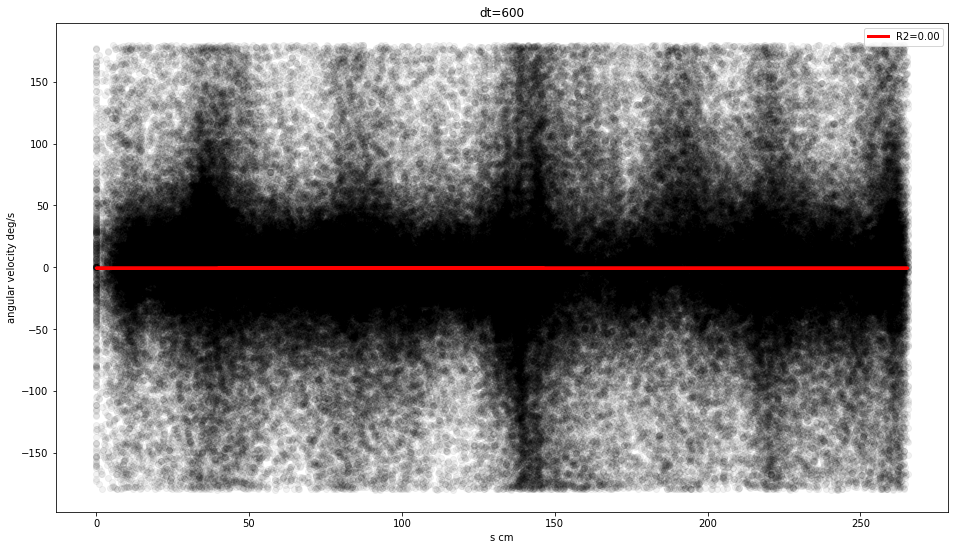

In [61]:
f, ax = plt.subplots(figsize=(16, 9))

ax.scatter(data.s, data.angular_velocity_400, color="k", alpha=.05)
ax.set(title=f"dt={dt}", xlabel="s cm", ylabel="angular velocity deg/s")
fit_line(data.s,  data.angular_velocity_400, ax)